# Jakub Bandurski, Michał Bryzik, Kacper Gruca
## Text Mining and Social Media Mining Project

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn_extra.cluster import KMedoids
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
import gensim
import pickle
import clust_functions as cf
import seaborn as sns
import warnings

In [3]:
df = pd.read_pickle('../data/tifu_cleaned_2.pkl')

## Clustering


In this section we will focus on utilizing different methods in order to clusterize the text from r/tifu subreddit.
Optimal cluster value will be selected utilizing silhouette value using MiniBatchKMeans in order to speed up the tuning process.


### Defining needed functions

For further information on function definition, check out funcs.py file where they are located.
We are using stardard Term frequency – inverse document frequency Vectorizer in order to represent subreddit posts as vectors. 

In [4]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=4353,
    stop_words='english'
)

text_tfidf = tfidf.fit_transform(df['documents_lem'])

#### Finding optimal clusters 

In [7]:
warnings.filterwarnings("ignore", category=FutureWarning)

Fit 2 clusters - Silhouette Score: 0.0040206048623286595
Fit 4 clusters - Silhouette Score: 0.001330140701878393
Fit 6 clusters - Silhouette Score: 0.0023513533328424867
Fit 8 clusters - Silhouette Score: 0.0015848913549479774
Fit 10 clusters - Silhouette Score: 0.0038991478211732673


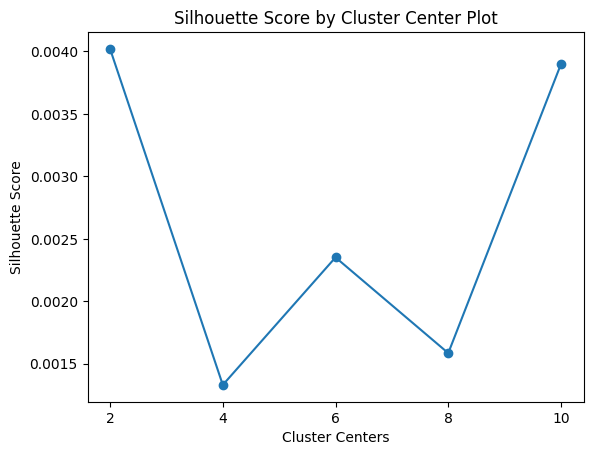

In [8]:
# Find optimal clusters
cf.find_optimal_clusters(text_tfidf, 10)

In [9]:
# MiniBatchKMeans & KMedoids
optimal_clusters = 6 
clusters_tfidf = MiniBatchKMeans(n_clusters=optimal_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_tfidf)
clusters_kmedoids = KMedoids(n_clusters=optimal_clusters, metric='cosine', random_state=20).fit_predict(text_tfidf)

As we can see from the chart above, a silhouette value indicates a decidedly weak/neutral assignment of values to clusters, a score close to 0 indicates observations that are on the borderline of several clusters. However we have decided to move on with analysis and see whether in fact there is no potential clustering method applicable that could categorize the text data in some way. As the optimal choice we have decided to go with 6 clusters, because of the seemingly still low amount of clusters and relatively high silhouette score.



#### KMedoids Clustering

Below can be seen 2D PCA and t-SNE representation of 6 clusters based on K-Medoids algorithm. The charts tentatively confirm our assumptions about low clusterization potential, especially in 2-dimensional space.

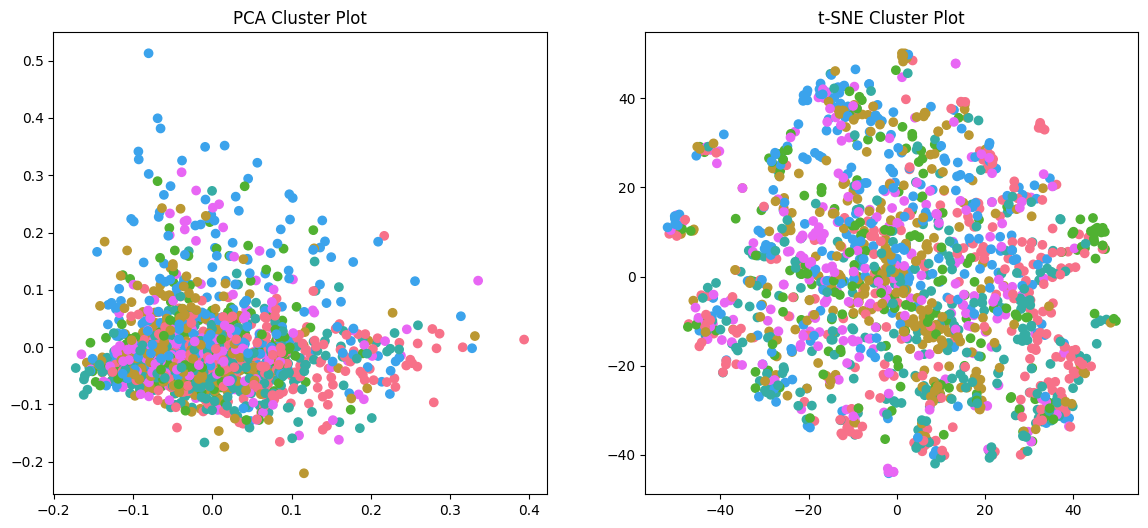

In [8]:
# Plotting PCA and t-SNE
cf.plot_tsne_pca(text_tfidf, clusters_kmedoids)
plt.show()

#### KMeans Clustering

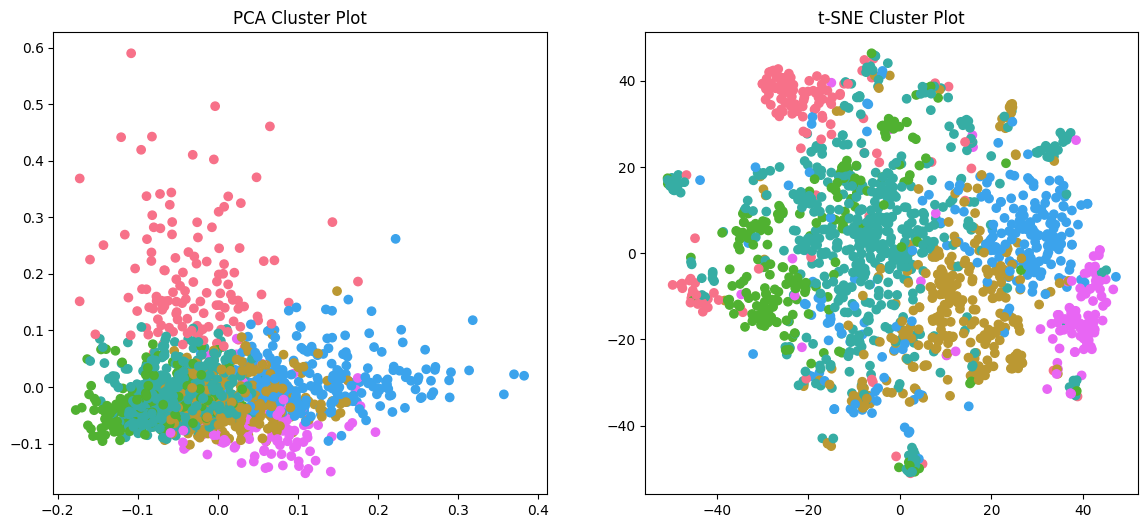

In [9]:
# Plotting PCA and t-SNE
cf.plot_tsne_pca(text_tfidf, clusters_tfidf)
plt.show()

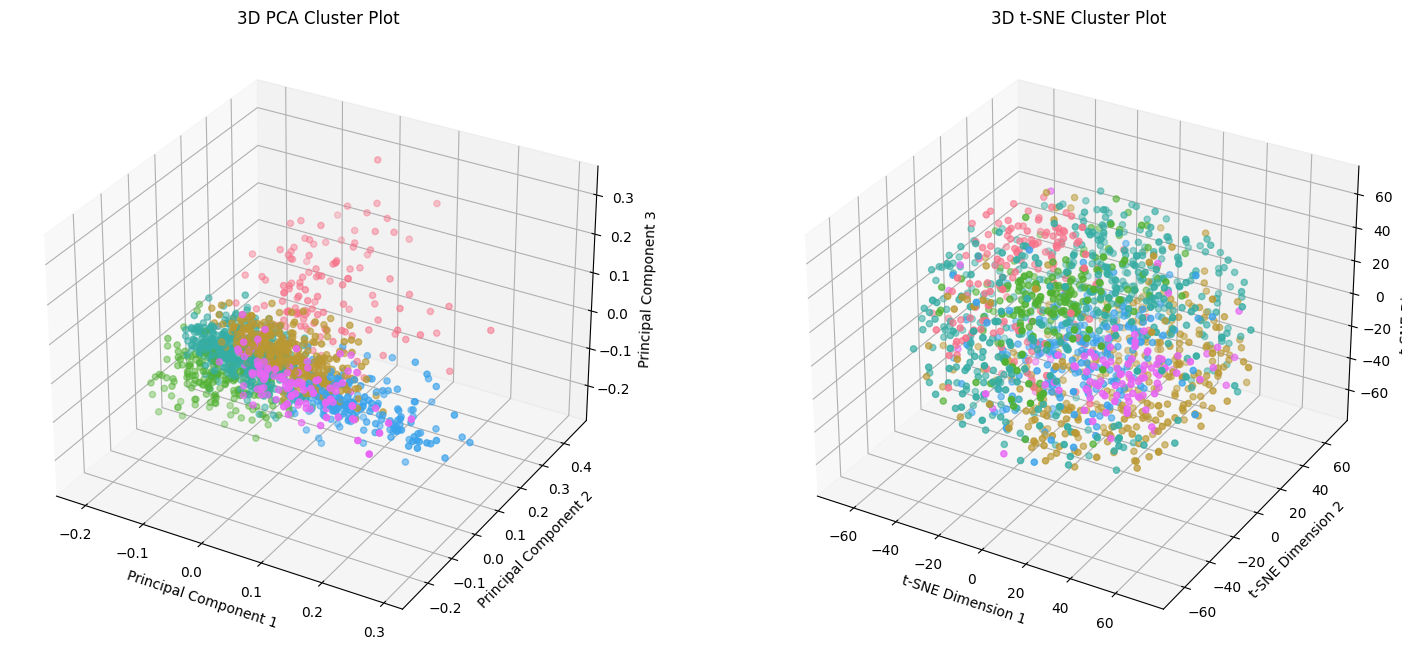

In [10]:
# 3D PCA plot function
cf.plot_3d_pca_tsna(text_tfidf, clusters_tfidf)


Comparing the two methods [K-means and K-medoids] We can assess that the k-means clustering visual representation seeems much more plausible taking into account 2/3 dimensional space. But let's also look at top words representation within clusters among those two algorithms.

In [21]:
print("Top terms per K-means clusters:")
cf.get_top_keywords(text_tfidf, clusters_tfidf, tfidf.get_feature_names_out(), 10)





Top terms per K-means clusters:

Cluster 0
kid,grade,friend,like,student,day,say,school,teacher,class

Cluster 1
look,say,start,house,key,home,road,drive,door,car

Cluster 2
make,look,ask,know,day,time,like,phone,work,say

Cluster 3
make,time,start,bottle,shit,like,shower,bathroom,toilet,water

Cluster 4
try,come,decide,make,day,happen,look,time,start,like

Cluster 5
want,really,know,time,start,talk,like,say,girl,friend


In [20]:
print("Top terms per K-Medoids clusters:")
cf.get_top_keywords(text_tfidf, clusters_kmedoids, tfidf.get_feature_names_out(), 10)

Top terms per K-Medoids clusters:

Cluster 0
happen,come,make,thing,say,day,feel,like,time,really

Cluster 1
come,day,year,start,say,like,talk,girl,school,friend

Cluster 2
know,come,year,job,like,make,time,ve,day,work

Cluster 3
work,start,walk,door,time,guy,say,look,like,phone

Cluster 4
happen,thing,make,look,day,time,know,start,like,say

Cluster 5
try,come,house,like,door,start,tell,say,friend,car


We can see that the word assignment highly differs depending on the cosen algorithm. However to most of the clusters we could theoretically assign specific characteristic. But let's also look and evaluate how clustering will work on our dataset if we utilize word embedding.

## Word Embedding

As we have already seen how the clustering works using TF-IDF vectorization, let's now try to use word embedding and see whether the clusters are calculated faster and more accurately. 

In [10]:
tokenized_sentences_lem = [sentence.split() for sentence in df['documents_lem']]
model = word2vec.Word2Vec(tokenized_sentences_lem,  vector_size=50, window=5, min_count=1, workers=10)

non_empty_tokenized_sentences = [doc for doc in tokenized_sentences_lem if doc]

embeddings = [np.mean([model.wv[word] for word in doc], axis=0) for doc in tokenized_sentences_lem]
embeddings_np = np.array(embeddings)
data_standardized = StandardScaler().fit_transform(embeddings)

In order to choose the cluster number on embeddings calculate optimal cluster number using silhouette score as an comparison metric.

Fit 2 clusters - Silhouette Score: 0.11414610095582339
Fit 4 clusters - Silhouette Score: 0.07286547485219576
Fit 6 clusters - Silhouette Score: 0.05649246536922455
Fit 8 clusters - Silhouette Score: 0.05386236827751309
Fit 10 clusters - Silhouette Score: 0.05383336897610532


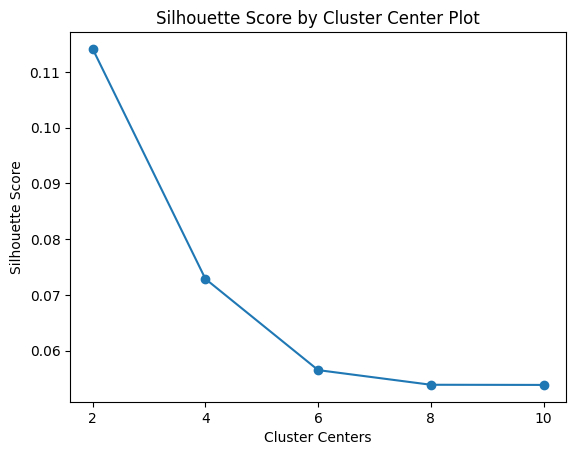

In [11]:
cf.find_optimal_clusters_with_embeddings(tokenized_sentences_lem, max_k=10)

##### Clustering on Embeddings [Kmeans]

In [12]:
clusters_kmeans = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(data_standardized)


###### 2D Graph [Kmeans]

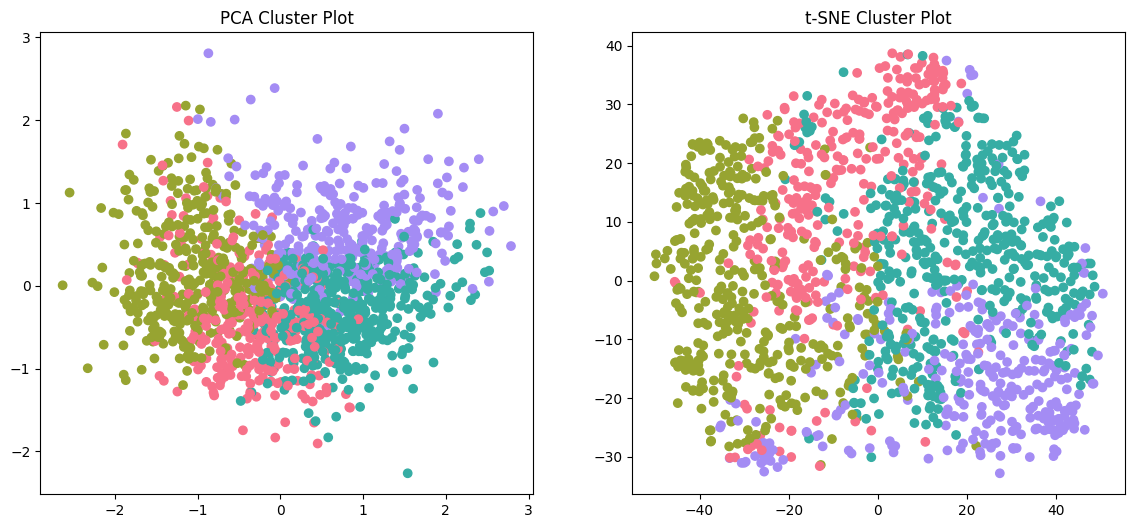

In [14]:
# Plotting PCA and t-SNE
cf.plot_tsne_pca_emb(embeddings_np, clusters_kmeans)


###### 3D Graph [Kmeans]

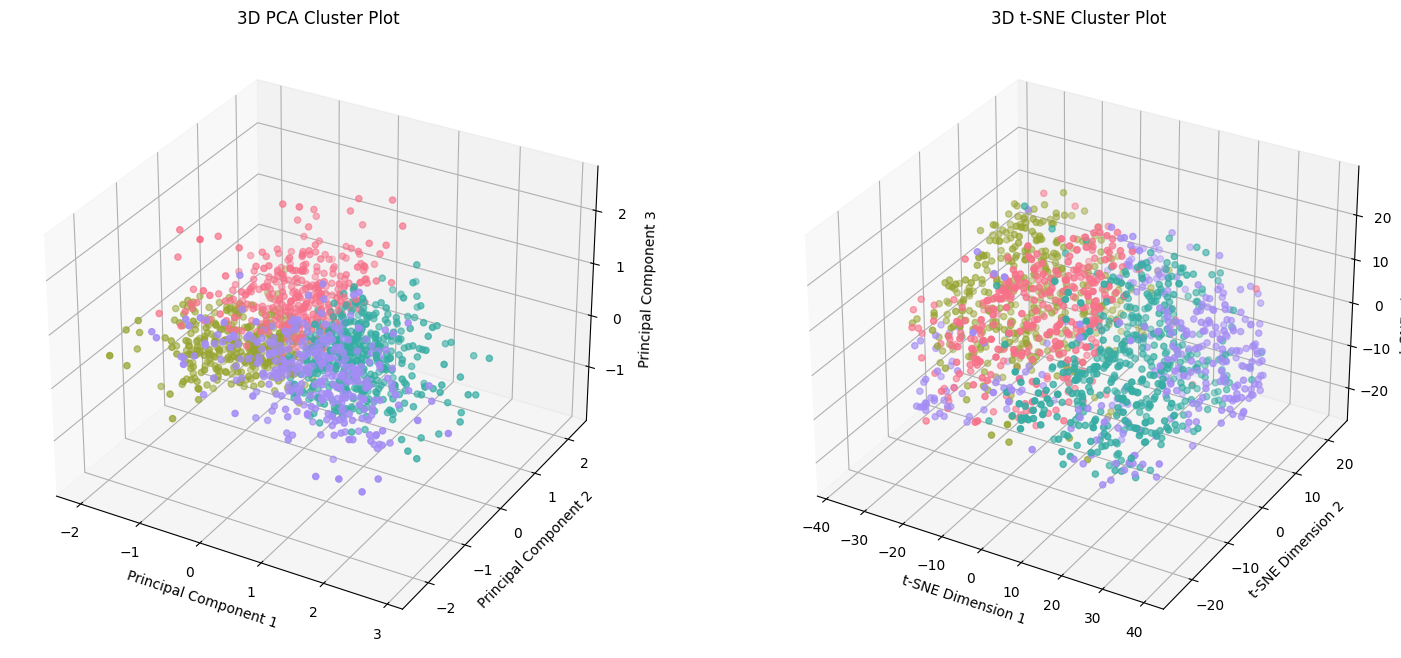

In [15]:
cf.plot_3d_pca_tsna_emb(embeddings_np, clusters_kmeans)

First thing to notice after using the word embedding is the speed of clustering algorithms. Much faster in comparison to previous calculations [using TF-IDF vectorization]
Additionally, the clusters calculate on word embeddings seem to be much better separated plotted on 2 and 3 dimensional space, especially compering them to the previous charts where we were using TF-IDF vectorization technique. The silhouette value (0.075) also resembles better cluster integrity for 4 clusters. 

Let's see now whether calculated clusters contain some cluster specific words/information.

In [16]:
cf.get_top_keywords(text_tfidf, clusters_kmeans, tfidf.get_feature_names_out(), 10)


Cluster 0
happen,start,decide,time,use,day,make,work,like,water

Cluster 1
time,walk,home,look,come,friend,work,phone,say,car

Cluster 2
time,class,know,school,year,talk,girl,like,friend,say

Cluster 3
come,happen,door,try,feel,bathroom,look,time,start,like


As an example let's see the differences between specific words between the clusters ;)

In [17]:
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'water')) 
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'home')) 
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'time')) 
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'work')) 

Cosine similarity between 'day' and 'bathroom':  0.46941563
Cosine similarity between 'day' and 'bathroom':  0.33650938
Cosine similarity between 'day' and 'bathroom':  0.20671858
Cosine similarity between 'day' and 'bathroom':  0.07737899
